# About
Code from Anthony Voto's [github repository](https://github.com/votoaj/Statistical_Consequences_of_Fat_Tails).

This is just a translation of the .py file to .ipynb format.

In [1]:
import pandas as pd
from scipy.stats import kurtosis, skew #set fisher = False
import scipy.stats as stats
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pylab

In [2]:
def MD(x):
    EX = np.mean(x)
    MD = np.mean(np.abs(x-EX))
    return MD

### import S&P500 data

In [3]:
spx = pd.read_excel('SPX.xlsx', sheet_name='spx')

daily_spx = np.array(spx['Adj Close'])
daily_spx = daily_spx[::-1]
logReturns = np.log(daily_spx[1:] / daily_spx[0:-1]) 

np.random.seed(0)
randGauss = np.random.normal(np.mean(logReturns),np.std(logReturns),len(logReturns))

### Visual Identification of Paretianity with Zipf plot or Log-Log

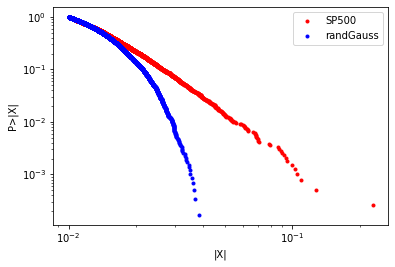

In [4]:
absLogReturns = sorted(np.abs(logReturns))
absLogReturns = [x for x in absLogReturns if x >= 0.01] #taleb only looks at absolute returns of 1% or greater?
survFunc = [(len(absLogReturns)-absLogReturns.index(i))/len(absLogReturns) for i in absLogReturns]


absRandGauss = sorted(np.abs(randGauss))
absRandGauss = [x for x in absRandGauss if x >= 0.01] #taleb only looks at absolute returns of 1% or greater?
survFuncGauss = [(len(absRandGauss)-absRandGauss.index(i))/len(absRandGauss) for i in absRandGauss]

#Figure 10.1
plt.loglog(absLogReturns,survFunc,'.',color='r',label='SP500')
plt.loglog(absRandGauss,survFuncGauss,'.',color='b',label='randGauss')
plt.xlabel('|X|')
plt.ylabel('P>|X|')
plt.legend()
#plt.savefig(r'C:\Figure10.1.png')

### Kurtosis and reshuffled at different time lags

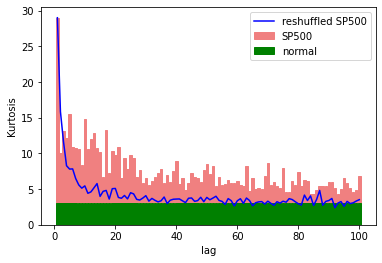

In [5]:
kurt_lag = []
reshuff_kurt_lag = []

random.seed(0)

for l in np.arange(1,101,1):
    
    logReturnsLag = np.array([sum(logReturns[x:x+l]) for x in range(0,len(logReturns),l)])
        
    reshuff_logReturns = random.sample(list(logReturns),len(logReturns))
    
    resshuffLag = np.array([sum(reshuff_logReturns[x:x+l]) for x in range(0,len(reshuff_logReturns),l)])

    
    kurt_l = kurtosis(logReturnsLag,fisher=False) # Fisher to False gives Pearson's definition (normal ==> 3)
    
    reshuff_kurt_l = kurtosis(np.array(resshuffLag),fisher=False) # Fisher to False gives Pearson's definition (normal ==> 3)
    
    kurt_lag.append(kurt_l) 
    reshuff_kurt_lag.append(reshuff_kurt_l)
    

#Figure 10.2
normal_kurt = [3]*len(kurt_lag)
#plt.stem(kurt_lag,markerfmt=' ',label='SP500')
plt.bar(np.arange(1,101,1),kurt_lag,color='lightcoral',ec='lightcoral',label='SP500')
plt.plot(np.arange(1,101,1),reshuff_kurt_lag,color='blue',label='reshuffled SP500')
plt.bar(np.arange(1,101,1),normal_kurt,color='green',ec='green',label='normal')
#plt.plot(normal_kurt ,color='green',label = 'normal')
plt.xlabel('lag')
plt.ylabel('Kurtosis')
plt.legend()

### weighted p-norm and corresponding Maximum to Sum (MS) plots

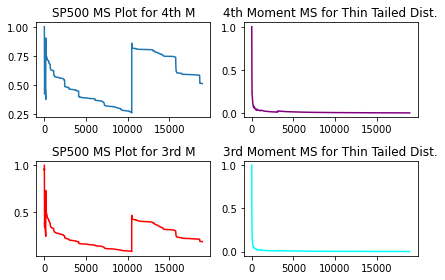

In [6]:
# historical S&P500

s3_t = np.cumsum(np.abs(logReturns)**3)
m3_t = pd.Series(np.abs(logReturns)**3).cummax()
r3_t = m3_t/s3_t

s4_t = np.cumsum(np.abs(logReturns)**4)
m4_t = pd.Series(np.abs(logReturns)**4).cummax()
r4_t = m4_t/s4_t

# thin tailed dist

s3_t = np.cumsum(np.abs(randGauss)**3)
m3_t = pd.Series(np.abs(randGauss)**3).cummax()
g3_t = m3_t/s3_t

s4_t = np.cumsum(np.abs(randGauss)**4)
m4_t = pd.Series(np.abs(randGauss)**4).cummax()
g4_t = m4_t/s4_t

#Figure 10.3
plt.subplot(2,2,1)
plt.plot(r4_t)
plt.title('SP500 MS Plot for 4th M')
plt.subplot(2,2,2)
plt.plot(g4_t,c='purple')
plt.title('4th Moment MS for Thin Tailed Dist.')
plt.subplot(2,2,3)
plt.plot(r3_t,c='red')
plt.title('SP500 MS Plot for 3rd M')
plt.subplot(2,2,4)
plt.plot(g3_t,'cyan')
plt.title('3rd Moment MS for Thin Tailed Dist.')
plt.tight_layout()
plt.show()

### Conditional Expectation below K as K varies

Text(0, 0.5, 'E[-X|-X>K] / K')

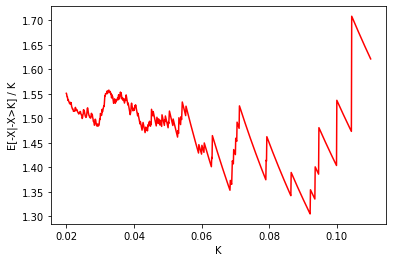

In [7]:
# if you use the same time frame as taleb your graph will look even closer

condexp = []

for k in np.arange(0.02,0.1101,0.0001):
    k_i = np.mean([-i for i in logReturns if -i>k])/k
    condexp.append(k_i)

#Figure 10.4    
plt.plot(np.arange(0.02,0.1101,0.0001),condexp,color='r')
plt.xlabel('K')
plt.ylabel('E[-X|-X>K] / K')

### Max Drawdowns

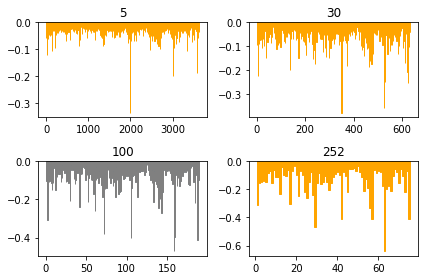

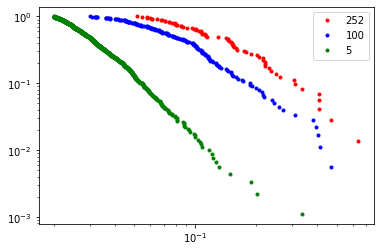

In [8]:
blocks = [5,30,100,252]
drawdowns = []
#block = 5

for block in blocks:
    drawdown = []
    
    for i in range(0,len(daily_spx)+1,block):
        if i + block > len(daily_spx):
            continue
        else:
            dds = [daily_spx[i+x+1:i+block+1]/daily_spx[i+x] for x in range(0,block)]
            dds = np.concatenate(dds)
            max_dd = np.log(min(dds))
            
        if max_dd > 0:
            continue
        else:
            drawdown.append(max_dd)
            
    drawdowns.append(drawdown)

#Figure 10.9
plt.subplot(2,2,1)
plt.bar(np.arange(1,len(drawdowns[0])+1),drawdowns[0],ec='orange',color='orange')
plt.title(str(blocks[0]))
plt.subplot(2,2,2)
plt.bar(np.arange(1,len(drawdowns[1])+1),drawdowns[1],ec='orange',color='orange')
plt.title(str(blocks[1]))
plt.subplot(2,2,3)
plt.bar(np.arange(1,len(drawdowns[2])+1),drawdowns[2],ec='grey')
plt.title(str(blocks[2]))
plt.subplot(2,2,4)
plt.bar(np.arange(1,len(drawdowns[3])+1),drawdowns[3],ec='orange',color='orange')
plt.title(str(blocks[3]))
plt.tight_layout()
plt.show()


absDD5 = sorted(np.abs(drawdowns[0]))
absDD5 = [x for x in absDD5 if x >= 0.02] #taleb only looks at absolute returns of 2% or greater?
survFunc5 = [(len(absDD5)-absDD5.index(i))/len(absDD5) for i in absDD5]


absDD100 = sorted(np.abs(drawdowns[2]))
absDD100 = [x for x in absDD100 if x >= 0.03] #taleb only looks at absolute returns of 3% or greater?
survFunc100 = [(len(absDD100)-absDD100.index(i))/len(absDD100) for i in absDD100]

absDD252 = sorted(np.abs(drawdowns[3]))
absDD252 = [x for x in absDD252 if x >= 0.05] #taleb only looks at absolute returns of 5% or greater?
survFunc252 = [(len(absDD252)-absDD252.index(i))/len(absDD252) for i in absDD252]

#Figure 10.10
plt.loglog(absDD252,survFunc252,'.',color='red',label='252')
plt.loglog(absDD100,survFunc100,'.',color='blue',label='100')
plt.loglog(absDD5,survFunc5,'.',color='green',label='5')
plt.legend()

### Gumbel Test of Independence

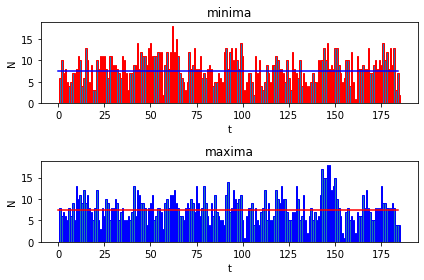

0.608

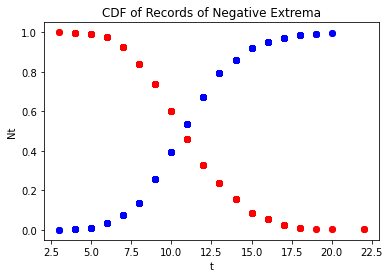

In [9]:
#tried to grab a subset of returns to get closer to Taleb's chart, using my full dataset results in slightly different chart but the end result is ultimately the same 


subLogReturns = logReturns[500:]

max_lst = pd.Series(subLogReturns).cummax()
min_lst = pd.Series(subLogReturns).cummin()

gains = np.cumsum([1] + [1 if max_lst[i] > max_lst[i-1] else 0 for i in range(1,len(max_lst))])
losses = np.cumsum([1] + [1 if min_lst[i] < min_lst[i-1] else 0 for i in range(1,len(min_lst))])
harmonic_num = [np.log(i) + np.euler_gamma for i in range(2,len(subLogReturns)+1)]

#Figure 10.15
plt.plot(gains,label='Gains',color='red')
plt.plot(losses,label='Losses',color='green')
plt.plot(harmonic_num,label = 'H(t)',color='blue')
plt.xlabel('time')
plt.ylabel('# records')
plt.legend()
           
negHarmonic = []
posHarmonic = []
for i in range(0,len(subLogReturns),100):
    max_lst = pd.Series(subLogReturns[i:i+1000]).cummax()
    min_lst = pd.Series(subLogReturns[i:i+1000]).cummin()
    
    gains_i = np.cumsum([1] + [1 if max_lst[i] > max_lst[i-1] else 0 for i in range(1,len(max_lst))])
    losses_i = np.cumsum([1] + [1 if min_lst[i] < min_lst[i-1] else 0 for i in range(1,len(min_lst))])
    
    
    
    negHarmonic.append(losses_i[-1])
    posHarmonic.append(gains_i[-1])

harmonic_1000 = [np.log(1000)+np.euler_gamma]*len(negHarmonic)

#Figure 10.16

plt.subplot(2,1,1)
plt.bar(np.arange(1,len(negHarmonic)+1),negHarmonic,ec='red')
plt.plot(harmonic_1000 ,color='b')
plt.title('minima')
plt.xlabel('t')
plt.ylabel('N')
plt.subplot(2,1,2)
plt.bar(np.arange(1,len(posHarmonic)+1),posHarmonic,ec='blue')
plt.plot(harmonic_1000 ,color='r')
plt.title('maxima')
plt.xlabel('t')
plt.ylabel('N')
plt.tight_layout()
plt.show()
#does taleb have these labeled incorrectly?  I think top should be minima and bottom should be maxima?  Difference could be how we shuffle. Either way, we reach the same conclusion



random.seed(0)

negN_t = []
posN_t = []

for i in range(1,1001):
    reshuff_logReturns = random.sample(list(logReturns),len(logReturns))
    max_lst = pd.Series(reshuff_logReturns).cummax()
    min_lst = pd.Series(reshuff_logReturns).cummin()
    
    gains_i = np.cumsum([1] + [1 if max_lst[i] > max_lst[i-1] else 0 for i in range(1,len(max_lst))])
    losses_i = np.cumsum([1] + [1 if min_lst[i] < min_lst[i-1] else 0 for i in range(1,len(min_lst))])
    
    negN_t.append(losses_i[-1])
    posN_t.append(gains_i[-1])

posN_t = sorted(posN_t)
negN_t = sorted(negN_t)

posNt_survFunc = [(len(posN_t) - posN_t.index(i))/len(posN_t) for i in posN_t]
negNt_CDF = [negN_t.index(i)/len(negN_t) for i in negN_t]

#Figure 10.17
plt.scatter(posN_t,posNt_survFunc,color='r')
plt.title('Survival Function of Records of Positive Maxima')
plt.xlabel('t')
plt.ylabel('Nt')
len([x for x in posN_t if x>16]) / len(posN_t)  #confirms taleb's result of 1/40 for mass above 16 in figure 10.17

#Figure 10.18
plt.scatter(negN_t,negNt_CDF,color='b')
plt.title('CDF of Records of Negative Extrema')
plt.xlabel('t')
plt.ylabel('Nt')
len([x for x in negN_t if x>9]) / len(negN_t) # taleb says 2/5 for mass above 9 in figure 10.18 but i am getting 3/5...just eyeballing his graph 3/5 seems correct, wonder if this is a typo

### Empirical Distribution of S&P500 using Standard T with 3 Degrees of freedom

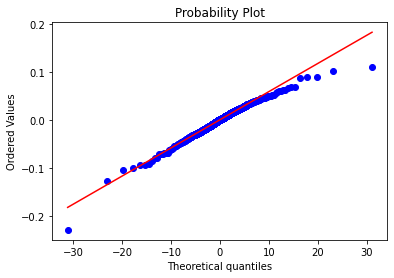

In [10]:
#Figure 10.14
stats.probplot(logReturns,dist=stats.t(3),plot=pylab)
#stats.probplot(logReturns,dist=stats.norm(0,1),plot=pylab)
pylab.show()

### positive vs negative returns

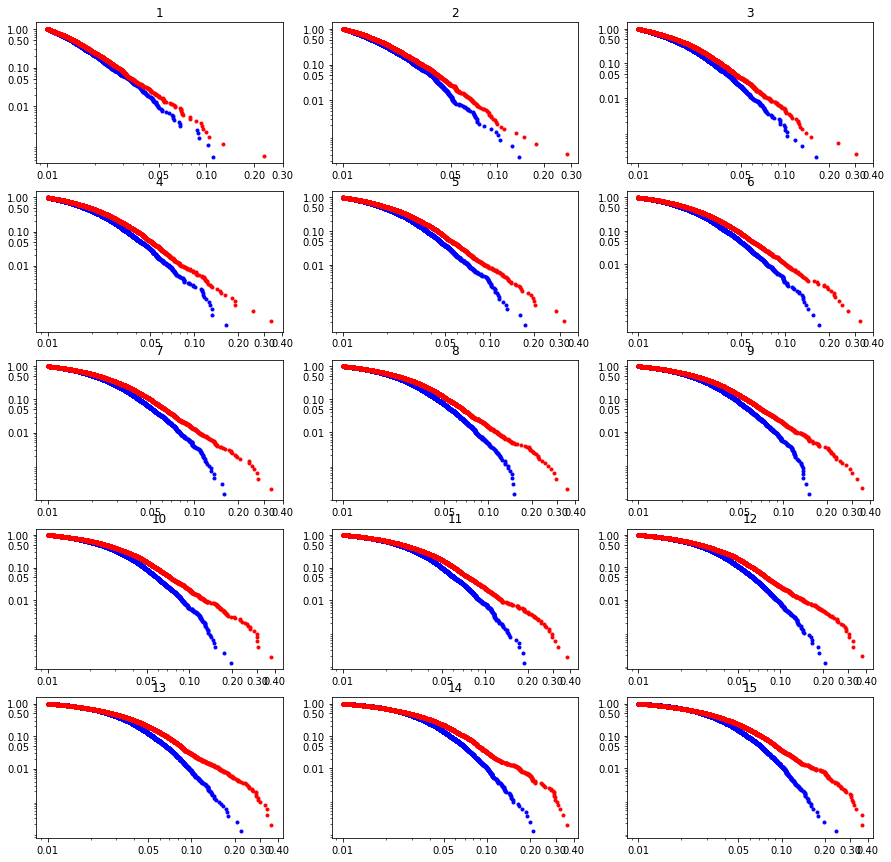

In [12]:
#Figure 10.13
days = np.arange(1,16,1)
fig = plt.figure()

for day in days:
    
    logReturns_n = [sum(logReturns[i:i+day]) for i in range(0,len(logReturns))]
    
    if day > 7:
        cutoff = 0.01
    else:
        cutoff = 0.01
    
    posLogReturns = sorted([x for x in logReturns_n if x >= cutoff])
    posRatio = len([x for x in logReturns_n if x >= cutoff]) / len([x for x in logReturns_n if x >= 0.0])
    negLogReturns = sorted([abs(x) for x in logReturns_n if x <= -1*cutoff]) #taleb only looks at absolute returns of 1% or greater?
    negRatio = len([x for x in logReturns_n if x <= -1*cutoff]) / len([x for x in logReturns_n if x < 0.0])
    posSurvFunc = np.array([(len(posLogReturns)-posLogReturns.index(i))/len(posLogReturns) for i in posLogReturns])
    negSurvFunc = np.array([(len(negLogReturns)-negLogReturns.index(i))/len(negLogReturns) for i in negLogReturns])

    ax = fig.add_subplot(5,3,day,title=str(day))
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    #ax.tight_layout()
    ax.loglog(posLogReturns,posSurvFunc,'.',color='b')
    ax.loglog(negLogReturns,negSurvFunc,'.',color='r')
    
    if day > 7:
        ax.set_xticks([0.01,0.05] + list(np.arange(0.1,round(max(negLogReturns),2)+0.1,0.1)))
    else:
        ax.set_xticks([0.01,0.05] + list(np.arange(0.1,round(max(negLogReturns),2)+0.1,0.1)))
    
    
    ax.set_yticks([0.01,0.05,0.1,0.5,1] )
    
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    

#plt.show()
#fig.savefig(r'C:\subplot.png')

### Kappa Metric

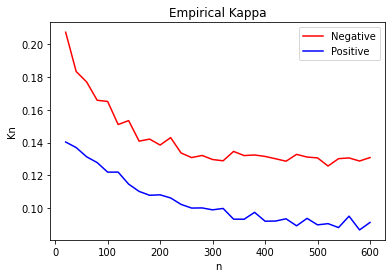

In [13]:
negLogReturns = [x for x in logReturns if x<0]
posLogReturns = [x for x in logReturns if x>0]

blocks = np.arange(20,620,20)
neg_kappas = []


for block in blocks:
    sample_size=10000
    random.seed(0)
    MD_D = MD([sum(random.choices(negLogReturns,k=1)) for idx in range(sample_size)])
    
    MD_N = MD([sum(random.choices(negLogReturns,k=block)) for idx in range(sample_size)])

    kappa_i = 2 - (np.log(block) - np.log(1))/np.log(MD_N/MD_D)
    neg_kappas.append(kappa_i)


pos_kappas = []


for block in blocks:
    
    sample_size=10000
    random.seed(0)
    MD_D = MD([sum(random.choices(posLogReturns,k=1)) for idx in range(sample_size)])
    
    MD_N = MD([sum(random.choices(posLogReturns,k=block)) for idx in range(sample_size)])

    kappa_i = 2 - (np.log(block) - np.log(1))/np.log(MD_N/MD_D)
    pos_kappas.append(kappa_i)

plt.plot(blocks,neg_kappas,label='Negative',color='r')
plt.plot(blocks,pos_kappas,label='Positive',color='b')
plt.title('Empirical Kappa')
plt.xlabel('n')
plt.ylabel('Kn')
plt.legend()